In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

# Automatically add the project root (1 level up) to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

# Exploratory Data Analysis

## Load Data

- Read the training dataset from a CSV file into a Pandas DataFrame.
- Display the first few rows to get an initial look at the data structure and key columns.


In [4]:
df = pd.read_csv(project_root+"/Data/train.csv")
df.head()

,EditType,EditID,comment,user,user_edit_count,user_distinct_pages,user_warns,user_reg_time,prev_user,common,...,num_recent_edits,num_recent_reversions,current_minor,current_timestamp,added_lines,previous_timestamp,deleted_lines,isvandalism,num_edits_5d_before,is_person
0,change,329595189,NaN,Nryan30,66,13,0,1259891940,219.78.124.42,NaN,...,0,0,False,1259894598,",==Leadership Through Emotion==,""Leadership is...",1259856305,NaN,False,1,0
1,change,232199357,/* Penis */,89.242.200.212,4,2,2,20080815230001,66.75.235.255,NaN,...,0,0,False,1218841201,It's fucking big.,1218816231,"""Falcon gained media attention after appearing...",True,4,1
2,change,329877752,Reverted edits by [[Special:Contributions/71.2...,Chamal N,18697,0,2,1208605428,71.208.113.72,NaN,...,2,1,True,1260025124,"""Japanese modern drama in the early twentieth ...",1260025104,""".nmbhgsdj;kfhds;akjfhds;fkjhsf;kjdshf;sdkjhfd...",False,3,0
3,change,253129486,NaN,Animaldudeyay1009,3,1,2,1227241317,J.delanoy,NaN,...,0,0,False,1227241840,I LIKE CHEESE. CHEESE IS GOOD. CHOCOLATE MILK ...,1227241120,"""A '''kaleidoscope''' is a tube of [[mirror]]s...",True,2,0
4,change,394520551,Adding Persondata using [[Project:AWB|AWB]] (7...,RjwilmsiBot,1602950,1309238,0,1257977968,LobãoV,NaN,...,0,0,True,1288757547,{{Persondata <!-- Metadata: see [[Wikipedia:Pe...,1285262356,",",False,0,1


## Handling Missing Data and Creating New Features

### Checking for missing values in the original data set

In [5]:
df.isnull().sum(axis=0)

EditType                     0
EditID                       0
comment                   7412
user                         0
user_edit_count              0
user_distinct_pages          0
user_warns                   0
user_reg_time                0
prev_user                    0
common                   25488
current                  25488
previous                 25488
page_made_time               0
title                        0
namespace                    0
creator                      0
num_recent_edits             0
num_recent_reversions        0
current_minor                0
current_timestamp            0
added_lines               1236
previous_timestamp           0
deleted_lines             4671
isvandalism                  0
num_edits_5d_before          0
is_person                    0
dtype: int64

We observe six columns with missing values. Below is a breakdown of each and how we handle them:

- **`comment`**: These missing values correspond to users leaving the comment field empty during an edit. This behavior may itself be informative (e.g., a lack of comment could signal vandalism), so we will **retain these rows** and consider encoding this as a separate feature.

- **`common`, `current`, `previous`**: These columns could not be retrieved from the API or the original XML file and are largely empty. As they don't contain usable data, we will **drop these columns**.

- **`added_lines`**: Missing values here are acceptable. Edits can consist solely of deletions or formatting changes, meaning no lines were added. Some entries may also contain `"BAD REQUEST"`, which indicates an API error — these will be **handled separately**.

- **`deleted_lines`**: Similar to `added_lines`, some edits may involve only additions or formatting, resulting in no deletions. `"BAD REQUEST"` entries will be addressed in the same manner as above.

### Handling "BAD REQUESTS" from API


In [6]:
bad_requests = df[
    (df["added_lines"] == "BAD REQUEST") | (df["deleted_lines"] == "BAD REQUEST")
]
print("Rows with 'BAD REQUEST':", bad_requests.shape[0])
df = df[
    ~((df["added_lines"] == "BAD REQUEST") | (df["deleted_lines"] == "BAD REQUEST"))
]

Rows with 'BAD REQUEST': 60


Some rows in the `added_lines` and `deleted_lines` columns contain the string `"BAD REQUEST"`, indicating failed API responses during data retrieval.

There were **60 such rows**, we chose to **remove them from the dataset**.

## Feature Engineering

### `comment_empty`

We create a new binary feature, `comment_empty`, which indicates whether the user left the comment field blank during their edit.


In [7]:
df["comment_empty"] = df.apply(comment_empty, axis=1)
df["comment_empty"].value_counts()  # Sanity check

comment_empty
False    18028
True      7400
Name: count, dtype: int64

### `account_age`

We create a new feature, `account_age`, which represents the number of days between a user's registration and the current edit. 

In [8]:
df["account_age"] = df.apply(account_age, axis=1)
df["account_age"].nunique()  # Sanity check

2105

### `is_IP`

We create a new binary feature, `is_IP`, which indicates whether the edit was made by an anonymous user (represented by an IP address) or a registered user (with a username).

In [9]:
df["is_IP"] = df.apply(is_IP, axis=1)
df["is_IP"].value_counts()  # Sanity check

is_IP
True     15669
False     9759
Name: count, dtype: int64

### `word_count_added` and `word_count_deleted`

We create two new features:

- `word_count_added`: The number of unique words added in a single edit.
- `word_count_deleted`: The number of unique words removed in a single edit.

In [12]:
df["word_count_added"], df["word_count_deleted"] = zip(*df.apply(word_count, axis=1))
print(df["word_count_added"].nunique())  # Sanity check
print(df["word_count_deleted"].nunique())  # Sanity check

938
1681


### `vandalism_score`

We create a new feature called `vandalism_score`, which estimates the likelihood that an edit is vandalism. This score is computed using a simple Naive Bayes-style method based on the **words added** in each edit.

#### How It Works

- Words that are frequently seen in past **vandalism edits** (e.g., profanity, repeated characters) increase the score.
- Words that are common in **non-vandalism edits** (e.g., neutral or technical terms) lower the score.
- The final score reflects how similar the added words are to patterns typically seen in vandalism.

#### Avoiding Data Leakage

Because this feature uses the `isvandalism` label during training, we need to avoid data leakage when computing it. To do this, we use **cross-validation**:

1. Split the training data into `K` folds.
2. For each fold:
   - Train the scoring model on the other `K - 1` folds.
   - Compute the `vandalism_score` for the current fold using this trained model.
3. Repeat for all folds so that each score is generated without access to its own label.

This ensures that the `vandalism_score` is a valid, leak-free input feature for any downstream machine learning model.


In [ ]:
scorer = VandalismScorer()
scorer.fit(df, df['isvandalism'])
df = scorer.transform(df)

df['vandalism_score'].nunique()

16840

## Outlier Detection

In [13]:
numeric_features = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "vandalism_score",
]
binary_features = ["comment_empty", "is_IP", "current_minor", "is_person"]
target = ["isvandalism"]

df[numeric_features].skew()

user_edit_count           7.909531
user_distinct_pages       9.529191
user_warns                5.829042
num_recent_edits          5.547609
num_recent_reversions     6.986149
num_edits_5d_before      15.781302
account_age               1.634759
word_count_added         28.339683
word_count_deleted       15.620992
vandalism_score           0.095728
dtype: float64

We observed that, with the exception of `vandalism_score`, all numerical features are highly right-skewed.

To improve interpretability and make patterns more visible in visualizations, we apply a log transformation (`log1p`) to these skewed features.

This transformation also helps stabilize variance and can improve performance for certain models.


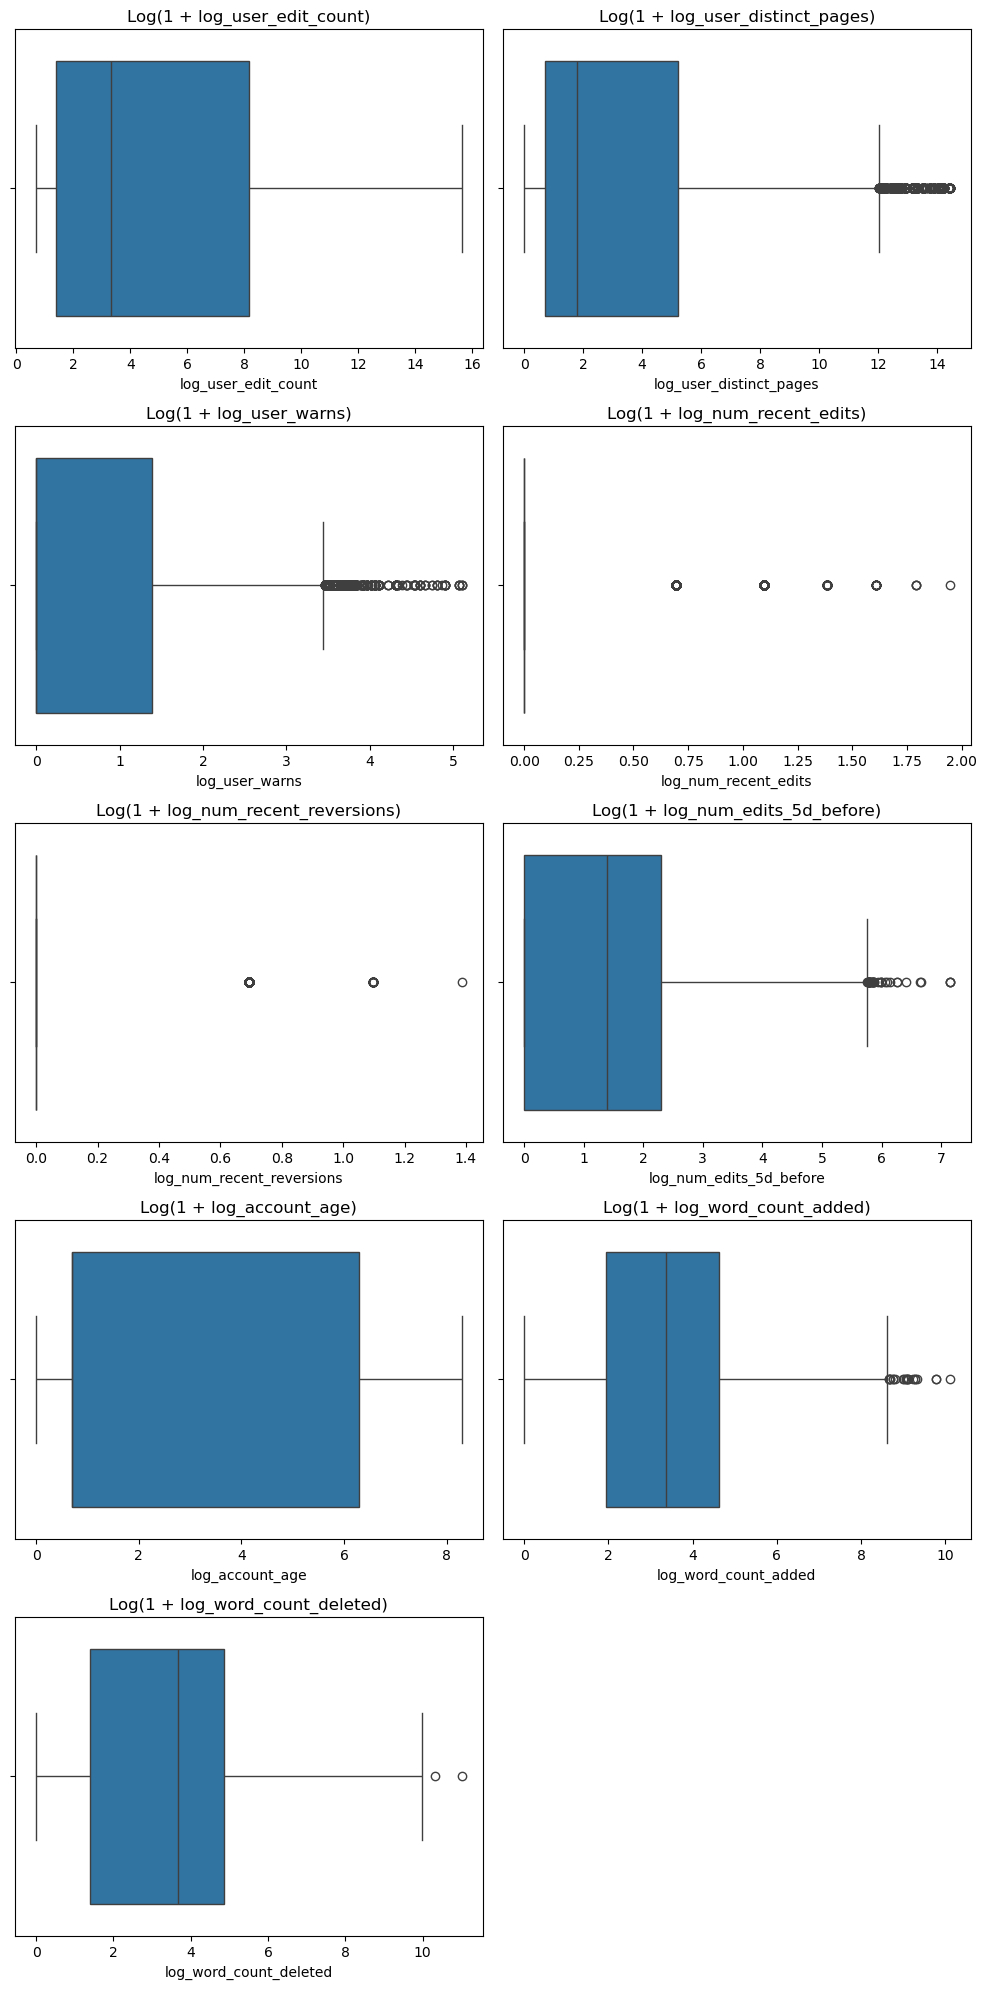

In [14]:
cols_to_transform = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
]

for col in cols_to_transform:
    df[f"log_{col}"] = np.log1p(df[col])

log_cols = [
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
]

n_cols = 2
n_rows = int(np.ceil(len(log_cols) / n_cols))

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(log_cols):
    plt.subplot(n_rows, n_cols, i + 1)

    sns.boxplot(df[col], orient="h")
    plt.title(f"Log(1 + {col})")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

From the previous box-plots, we observe a high number of outliers in features such as `log_user_warns`, `log_user_distinct_pages`, `log_num_edits_5d_before`, and `log_word_count_added`.

While these values are extreme, they may still carry important signals related to vandalism. Therefore, we **do not remove them** at this stage to avoid discarding potentially informative data.


## Relationship Between Numerical Predictors and Target

To understand how each numerical feature relates to the target variable (`isvandalism`), we generate Kernel Density Estimation (KDE) plots for each feature, separated by class.

These plots help us visually assess whether the distribution of a feature differs between vandalism and non-vandalism edits, which can indicate its predictive value.


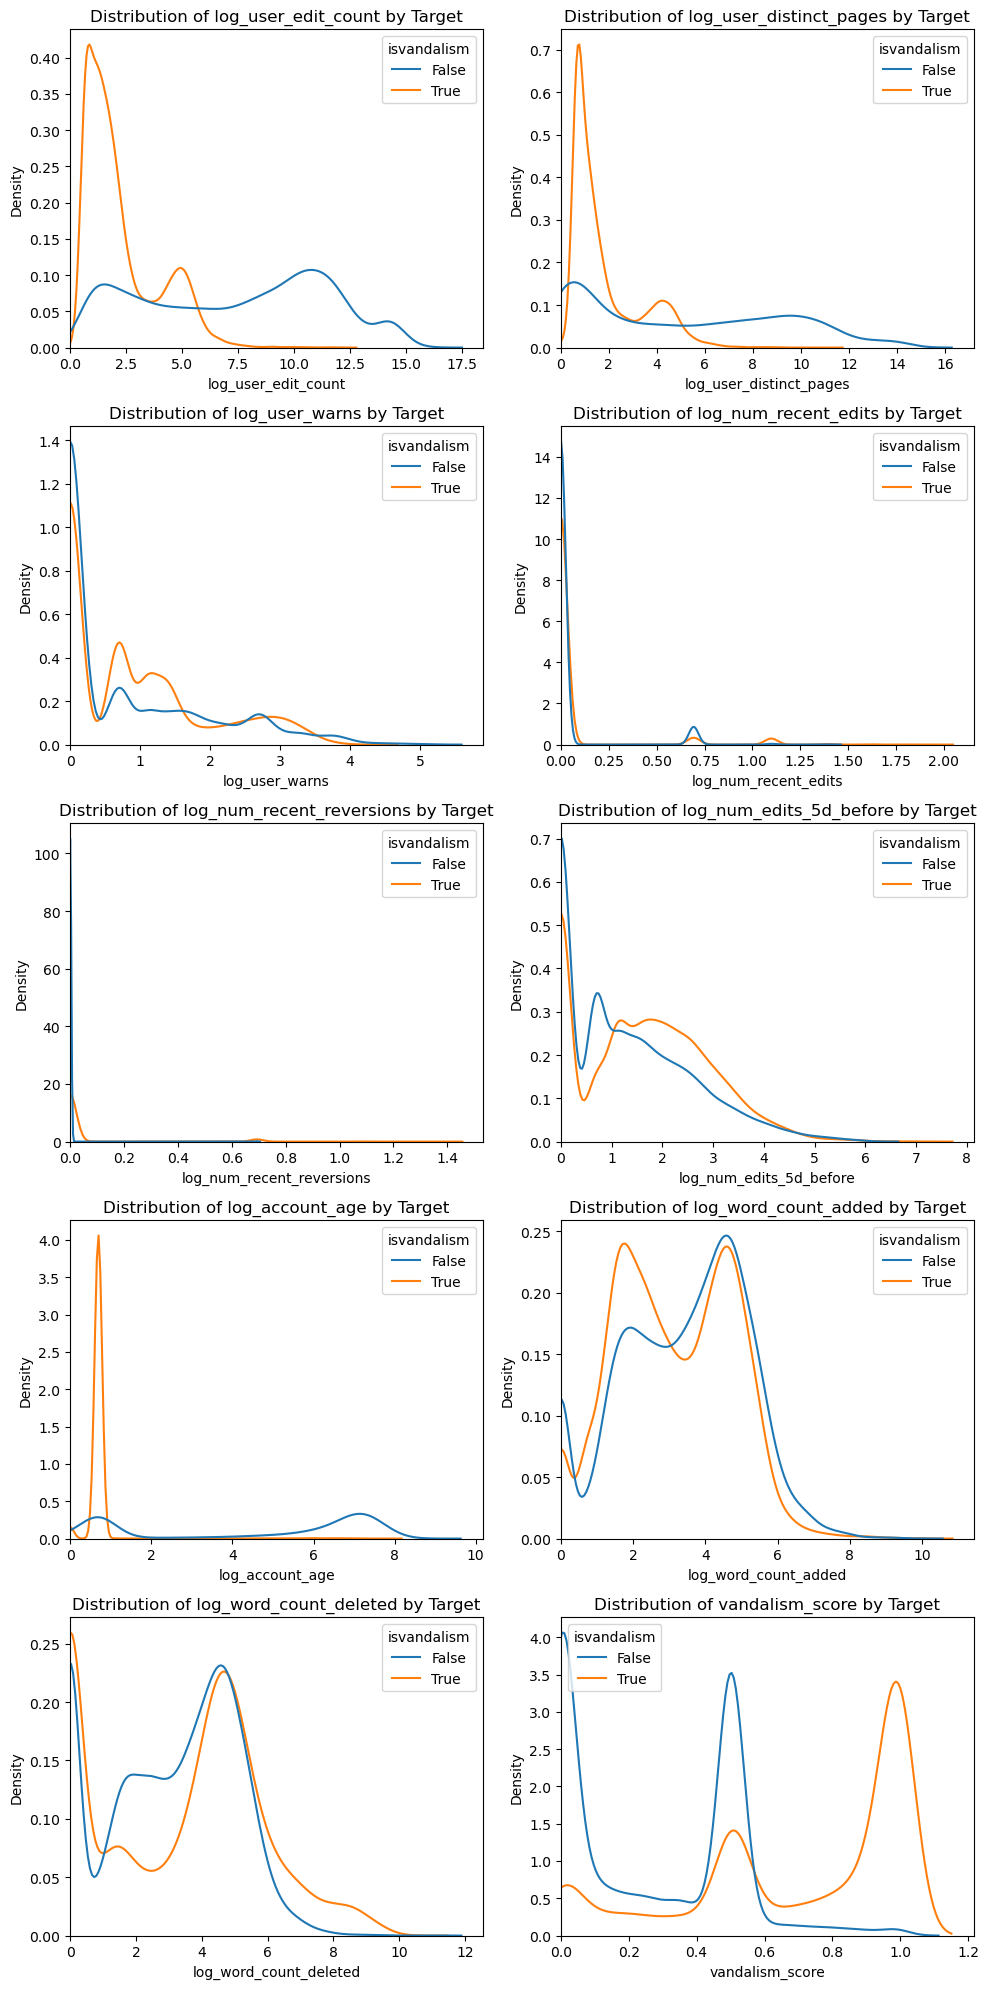

In [ ]:
cols_to_plot = [
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
    "vandalism_score",
]

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(data=df, x=col, hue="isvandalism", common_norm=False)
    plt.xlim(left=0)
    plt.title(f"Distribution of {col} by Target")
    plt.xlabel(col)
    plt.ylabel("Density")


plt.tight_layout()
plt.show()

### Analyzing KDE Plots

The KDE plots reveal that, with the exception of `log_num_recent_reversions`, most predictors display **multimodal distributions** across both classes (`isvandalism = 0` and `1`). This suggests that the relationship between these features and the target variable is likely **non-linear** and may involve interactions with other features. As a result, linear models like logistic regression may struggle unless additional features are engineered or nonlinear transformations are applied.

Below is a summary of each feature's observed behavior:

- **`log_user_edit_count`**: Vandalism cases are concentrated at **lower values**, making this a strong indicator of vandalism. Non-vandalism dominates the **higher range**, giving this feature clear discriminatory power.

- **`log_user_distinct_pages`**: Similar to `log_user_edit_count`, vandalism tends to occur when users have edited fewer distinct pages. Non-vandalism dominates the higher end.

- **`log_user_warns`**: Shows considerable overlap between classes. While there's a small region where vandalism dominates, this feature appears to be a **weak standalone predictor**, though potentially useful in combination with others. Non-vandalism appears to dominate extreme values.

- **`log_num_recent_edits`**: Also shows **class overlap**, though vandalism seems to dominate the **higher range**. Like `log_user_warns`, this feature may gain value when combined with others.

- **`log_num_recent_reversions`**: Exhibits class overlap, but **differences in tail behavior** (e.g., one class tapering off earlier) suggest some predictive potential at the extremes.

- **`log_num_edits_5d_before`**: Both classes have **small, distinct peaks**, suggesting a modest degree of separation. There is considerable overlap.

- **`log_account_age`**: Vandalism is more common among **newer accounts**, while non-vandalism dominates at **higher account ages**. This makes it a **useful and interpretable predictor**.

- **`log_word_count_added`**: Displays significant class overlap, with vandalism slightly more frequent in a small region. Not strongly predictive on its own.

- **`log_word_count_deleted`**: Both classes dominate in different intervals, with some overlap. Shows modest potential depending on the region.

- **`vandalism_score`**: Shows **significant separation** — low scores align with non-vandalism, high scores with vandalism. Both distributions appear bimodal, well separated at the extremes but with significant overlap around `vandalism_score = 0.5`. The location of the overlap suggests that these are edits containing words that the Bayes classifier has rarely seen, and the vandalism edits in this region could indeed be novel ways of vandalizing Wikipedia.




## Relationship Between Binary Predictors and the Target

To better understand how each binary predictor relates to the target variable (`isvandalism`), we generate bar plots showing the proportion of vandalism within each category of the binary features. These plots help us assess whether certain feature values are associated with a higher or lower likelihood of vandalism.


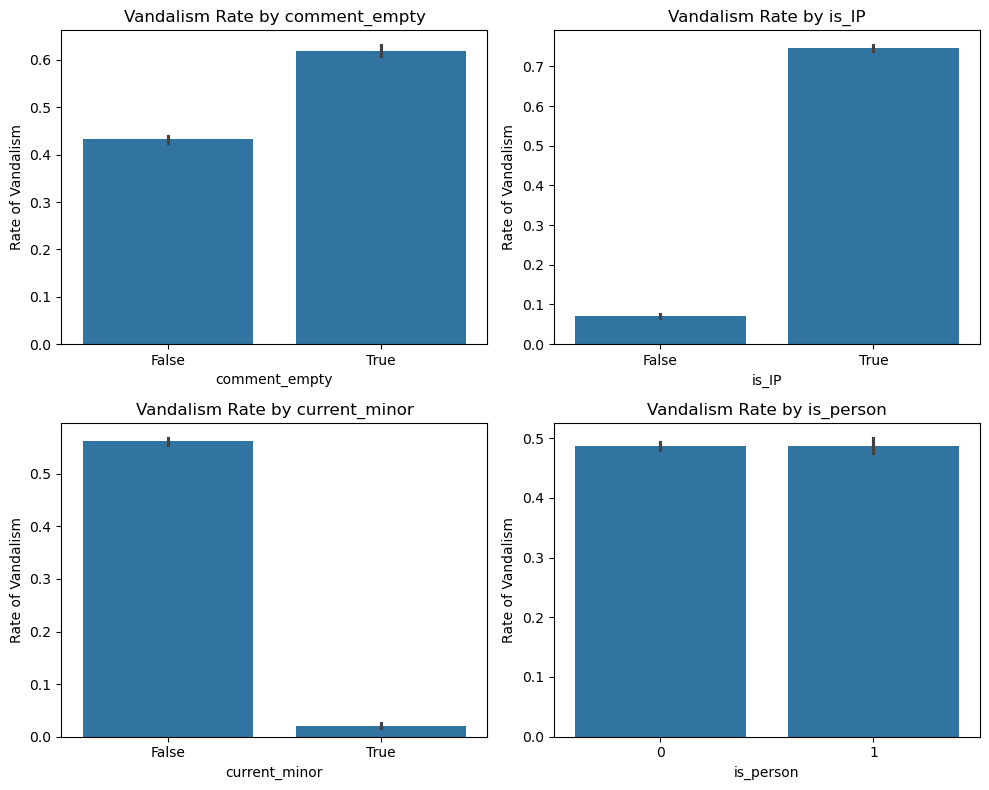

In [18]:
cols_to_plot = ["comment_empty", "is_IP", "current_minor", "is_person"]

n_cols = 2
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(data=df, x=col, y="isvandalism")
    plt.title(f"Vandalism Rate by {col}")
    plt.xlabel(col)
    plt.ylabel("Rate of Vandalism")


plt.tight_layout()
plt.show()

### Analyzing Bar Plots

- **`comment_empty`**:  The plot shows a similar rate of vandalism across both categories, with a slightly higher rate when the comment section is empty. This suggests a weak but potentially useful signal.

- **`is_IP`**:  This appears to be a strong predictor. The rate of vandalism is significantly higher when the user is identified by an IP address rather than a registered username, which aligns with expectations about anonymous edits.

- **`current_minor`**:  Another strong predictor. The rate of vandalism is much higher when the edit is **not** marked as minor, indicating that major edits may be more suspicious.

- **`is_person`**:  This seems to be a weak predictor. The vandalism rate is nearly identical regardless of whether the article refers to a person or not, suggesting limited predictive value.


## Correlations

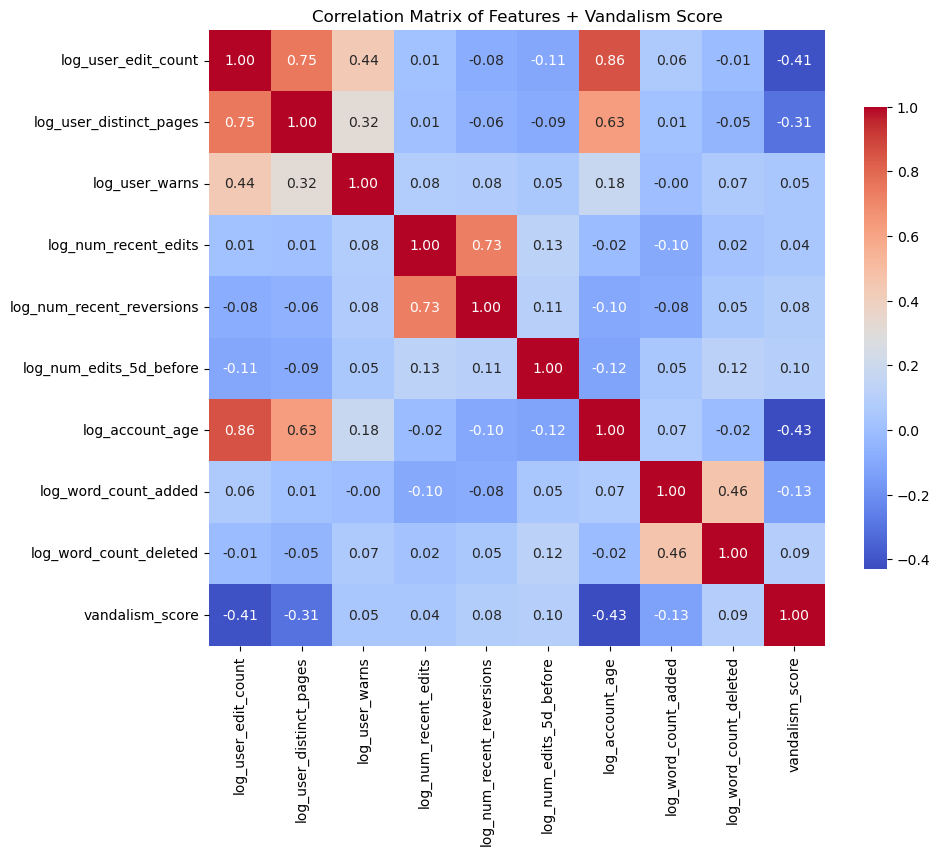

In [19]:
cols = [
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
    "vandalism_score",
]

corr_matrix = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.75},
)
plt.title("Correlation Matrix of Features + Vandalism Score")
plt.show()

### Correlation Insights

There appears to be **small to moderate correlation** between several variables. The following pairs exhibit **strong correlation**:

- `log_user_edit_count` and `log_account_age` (0.86)  
- `log_user_edit_count` and `log_user_distinct_pages` (0.75)

> **Note:** Strong correlation indicates **redundancy** between features. This can negatively impact models such as **logistic regression**.